# Import

In [1]:
import random
import os
from collections import defaultdict
from tqdm import tqdm
import csv
from datetime import datetime


import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import recall_score, classification_report, confusion_matrix, make_scorer
import xgboost as xgb
import matplotlib.pyplot as plt


def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

def log(record, name: str = 'log__feature_selection.csv'):
    with open(name, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, delimiter=';', dialect='excel')
        writer.writerow([datetime.now()] + [record])
    


random_seed = 1234
set_all_seeds(random_seed)

# Parameters

In [2]:
dataset_path = 'data/dataset_after_eda.parquet'
target_column = 'target'
datetime_column = '17'

# Feature selection

## Upload data

In [4]:
df = pd.read_parquet(dataset_path)
df.head()

,0,2,3,4,5,6,7,8,9,10,...,435,436,437,438,non_zero_count,389_more_than_8,389_more_than_58,389_complex,10_more_than_4,101_more_than_4
0,1,0,0,1,0,3,2,91,0,1,...,0,0,0,20,152,True,False,True,False,False
1,1,0,0,1,0,3,2,61,0,0,...,0,0,0,10,117,False,False,False,False,False
2,1,0,0,0,0,2,3,21,1,1,...,20,0,0,0,99,False,False,False,False,False
3,4,0,0,0,0,6,3,92,0,4,...,0,10,14,4,146,True,False,True,True,False
4,1,0,0,0,0,2,2,11,0,1,...,0,0,0,0,85,False,False,False,False,False


## Correlation

In [7]:
numeric_cols = df.drop(columns=[target_column]).select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]
corr_matrix = df_numeric.corr().abs() 

high_corr_pairs = []
threshold = 0.99
p_value_threshold = 0.15

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            
            _, p_value = pearsonr(df_numeric[col1], df_numeric[col2])
            if p_value < p_value_threshold:  # Проверяем статистическую значимость
                high_corr_pairs.append((col1, col2))

cols_to_drop = set() 

for col1, col2 in high_corr_pairs:
    cols_to_drop.add(col2)
    
print(cols_to_drop)

{'252', '414', '127', '228', '398', '226', '209', '109', '396', '243', '380', '98', '271', '268', '194', '400', '394', '429', '120', '239', '215', '181', '180', '416', '67', '256', '151', '419', '240', '158', '34', '164', '258', '424', '415', '168', '438', '283', '403', '152', '102', '60', '129', '225', '169', '409', '83', '26', '406', '413', '200', '244', '247', '430', '266', '96', '410', '161', '251'}


In [6]:
# remove high-correlated columns
cols_to_drop = ['252', '414', '127', '228', '398', '226', '209', '109', '396', '243', '380', '98', '271', '268', '194', '400', '394', '429', '120', '239', '215', '181', '180', '416', '67', '256', '151', '419', '240', '158', '34', '164', '258', '424', '415', '168', '438', '283', '403', '152', '102', '60', '129', '225', '169', '409', '83', '26', '406', '413', '200', '244', '247', '430', '266', '96', '410', '161', '251']

df = df.drop(columns=cols_to_drop)

## Add-del process

### Functions

In [7]:
def model_report(y_true, y_pred, model_name = '_'):
    print('\n---------------------------------------------------------------')
    print(f"Model: {model_name}")
    print(f"Test data length: {len(y_true)}")
    print(f"Fraud sessions in test data: {sum(y_true)}")
    
    print(classification_report(y_true, y_pred))
    
    if len(set(y_true))>1:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()        
        
        print(f'\nTN: {tn}')
        print(f'FP: {fp}')
        print(f'FN: {fn}')
        print(f'TP: {tp}')   
        
        fpr = fp/(fp+tn) 
        fnr = fn/(fn+tp)
        print('False Negative Rate (fn/(fn+tp),<0.05) = ',fnr)
        print('False Positive Rate (fp/(fp+tn),<0.01) = ',fpr)
    else:
        print('One label, fpr is out function scope.')
        

def find_threshold_fpr(y_true, y_pred_proba, target_fpr):
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_pred_proba_sorted = y_pred_proba[sorted_indices]
    false_pos = 0.0
    threshold = 0.0
    for i in range(len(y_true_sorted)):
        if y_true_sorted[i] == 0:
            false_pos += 1
        if false_pos / len(y_true_sorted) >= target_fpr:
            threshold = y_pred_proba_sorted[i]
            break
    return threshold


def get_recall_on_fpr(y_true, y_proba, target_fpr):
    threshold = find_threshold_fpr(y_true, y_proba, target_fpr)
    y_pred_binary = np.where(y_proba >= threshold, 1, 0)
    score = recall_score(y_true, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    fpr = fp / (fp + tn)
    if fpr > target_fpr * 2:
        return 0
    return score


def train_test_split_df(X, 
                        y, 
                        class_probabilities={0:0.2,1:0.2}, 
                        shuffle=True,
                        random_state=random_seed):
    """
    A dictionary of shares is used with each class. These data shares are recorded for sample in the test set.
    Example: {0:0.02, 1:0.02}
    return:
        X_train, X_test, y_train, y_test
    """
    
    if random_state is not None:
        random.seed(random_state)

    class_indices = defaultdict(list)

    for idx, label in enumerate(y.to_numpy()):
        class_indices[label].append(idx)

    X_train, X_test, y_train, y_test = [], [], [], []

    for label, prob in class_probabilities.items():
        indices = class_indices[label]
        split_index = int((1 - prob) * len(indices))
        if shuffle:
            random.shuffle(indices)

        train_indices, test_indices = indices[:split_index], indices[split_index:]

        X_train.append(X.iloc[train_indices])
        X_test.append(X.iloc[test_indices])
        y_train.append(y.iloc[train_indices])
        y_test.append(y.iloc[test_indices]) 
        
    X_train = pd.concat([*X_train],ignore_index=True)
    X_test = pd.concat([*X_test],ignore_index=True)
    y_train = pd.concat([*y_train],ignore_index=True)
    y_test = pd.concat([*y_test],ignore_index=True)
    
    return X_train, X_test, y_train, y_test


def plot_daily_count(df, target):
    plotdf = df[[target_column, datetime_column]].copy()
    plotdf['date'] = plotdf[datetime_column].dt.date
    daily_counts = plotdf[plotdf[target_column]==target].groupby('date').count()


    plt.figure(figsize=(12, 6))
    ax = daily_counts.plot(legend=True)
    ax.set_xlabel('Date')
    ax.set_ylabel('Count')
    ax.set_title(f'Daily Count of {target_column} = {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend(['Count'])
    plt.grid(True)
    plt.show()
    

def make_test(df, target_column, datetime_column, split_date, class_0_share=0.1):
    
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    
    dt_train_fraud = df[(df[datetime_column] < split_date) & (df[target_column]==1)]
    df_test_fraud = df[(df[datetime_column] >= split_date) & (df[target_column]==1)]
                        
    df_test_clear = df[df[target_column]==0].sample(frac=class_0_share)
    df_train_clear = df[df[target_column]==0].drop(df_test_clear.index)
    
    train = pd.concat([dt_train_fraud, df_train_clear],ignore_index=True).drop(columns=[datetime_column])
    test = pd.concat([df_test_fraud, df_test_clear],ignore_index=True).drop(columns=[datetime_column])
    
    return train,test
           
    

### Add-del loop

#### Time split

Target=1: left border 2024-10-18 11:54:27.370000, right border 2025-05-13 21:40:30.696000
Target=0: left border 2025-03-19 21:00:16.797000, right border 2025-05-07 20:59:51.076000


<Figure size 864x432 with 0 Axes>

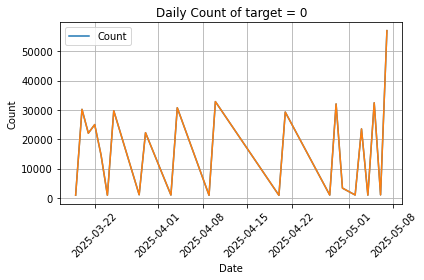

<Figure size 864x432 with 0 Axes>

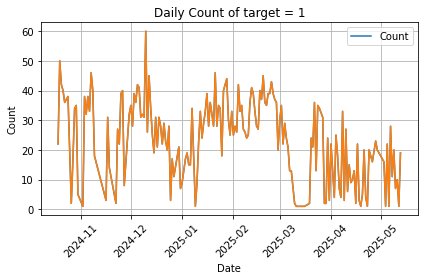

In [8]:
# let see on time intervals to split
for i in [1,0]:
    print(f"Target={i}: left border {df[df[target_column]==i][datetime_column].min()}, right border {df[df[target_column]==i][datetime_column].max()}")
    

plot_daily_count(df, 0)
plot_daily_count(df, 1)

In [9]:
df[df[datetime_column]>=pd.Timestamp('2025-04-15 00:00:00')][target_column].value_counts(),\
df[df[datetime_column]<pd.Timestamp('2025-04-15 00:00:00')][target_column].value_counts()

(0.0    182355
 1.0       286
 Name: target, dtype: int64,
 0.0    212084
 1.0      4010
 Name: target, dtype: int64)

In [10]:
train_val_df, test_df = make_test(df, target_column, datetime_column, pd.Timestamp('2025-04-15'), class_0_share=0.1)

print('Train & validation labels: ',train_val_df[target_column].value_counts())
print('\nTest labels: ', test_df[target_column].value_counts())

Train & validation labels:  0.0    354995
1.0      4010
Name: target, dtype: int64

Test labels:  0.0    39444
1.0      286
Name: target, dtype: int64


#### Share split

In [11]:
X_train, X_val, y_train, y_val = train_test_split_df(train_val_df.drop(columns=[target_column]),
                                                     train_val_df[target_column], 
                                                     class_probabilities={0:0.1, 1:0.1}, 
                                                     shuffle=True,
                                                     random_state=random_seed)
print('Train labels: ', y_train.value_counts())
print('Validation labels: ', y_val.value_counts())

Train labels:  0.0    319495
1.0      3609
Name: target, dtype: int64
Validation labels:  0.0    35500
1.0      401
Name: target, dtype: int64


#### Stage 1 - Backward Elimination

In [13]:
params = {'objective': 'binary:logistic', 
         'n_estimators':100,
         'random_state':random_seed}


custom_metric = make_scorer(
    get_recall_on_fpr,
    needs_proba=True, 
    target_fpr=0.00005   
)

C:\PROGRAMS\Anaconda\lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [14]:
model = xgb.XGBClassifier(**params)
model.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
model.predict_proba(X_val)

In [ ]:
model = xgb.XGBClassifier(**params)
model.fit(X_train,y_train)

init_minimum = get_recall_on_fpr(y_val, model.predict_proba(X_val), target_fpr)

value_dict = dict(sorted(zip(X_train_val.columns,
                             model.feature_importances_), 
                         key=lambda item: item[1], 
                         reverse=False)
                 )

init_set = set(value_dict)
minus_set = []

print('Первоначальный минимум (FN) = ', minimum_)

for j in set(value_dict):
    if j not in minus_set:
        minus_set.append(j)
        _ = init_set - set(minus_set)
        sup = []

        for i in [None, 42, random_seed]:

            model1 = xgb.XGBClassifier(objective = 'binary:logistic',
                                       random_state = i)
            model1.fit(X_train_val[_],y_train_val)
            sup.append(np.count_nonzero((y_test == 1) & (model1.predict(X_test[_]) == 0)))

        if max(sup) <= minimum_:
            print(f'Убираем {j}; Длина списка на удаление = ', len(minus_set))
        else:
            minus_set.remove(j)
            print('Признак ', j,' : ', sup)

#### Stage 2 - Permutation feature importance with random feature

In [ ]:
n_repeats_for_permutation_importance = 10
n_splits_for_cv = 5

In [ ]:
log('Stage 2 - Permutation feature importance with random feature')

rng = np.random.default_rng(seed=random_seed)
X_train['random'] = rng.choice(list(range(100)), size=len(X_train))
X_val['random'] = rng.choice(list(range(100)), size=len(X_val)) 


    
scorer = make_scorer(custom_metric,
                     greater_is_better=True)

selection_model = xgb.XGBClassifier(**param)
selection_model.fit(X_train,y_train)
permutation_result = permutation_importance(selection_model, 
                                            X_val, 
                                            y_val, 
                                            n_repeats=n_repeats_for_permutation_importance, 
                                            random_state=random_seed,
                                            scoring=scorer)
log('Stage 2 end')

In [ ]:
permutation_df = pd.DataFrame(index = X_train.columns,
                              data = {'importance_mean':permutation_result.importances_mean,
                                      'importance_std':permutation_result.importances_std,
                                      'all_positive':[0 not in np.where(x>0,1,0) for x in permutation_result.importances],
                                      'mean-std':permutation_result.importances_mean-permutation_result.importances_std})

stat1 = permutation_df.loc[(permutation_df['importance_mean']>permutation_df.loc['random','importance_mean'])&(permutation_df['mean-std']>0)]
stat2 = permutation_df.loc[(permutation_df['importance_mean']>permutation_df.loc['random','importance_mean'])&(permutation_df['all_positive'] == True)]

print('Нестрогий набор: ', stat1.index)
print('Строгий набор: ', stat2.index)

def features_checker(feature_list):
    model = xgb.XGBClassifier(objective = 'binary:logistic',
                              random_state = None)

    cv = StratifiedKFold(n_splits=n_splits_for_cv, 
                         shuffle=True, 
                         random_state=random_seed)

    cv_results = cross_validate(model, 
                                X_train_val[feature_list], 
                                y_train_val, 
                                cv=cv,
                                scoring = scorer, 
                                n_jobs=1) 
    return cv_results

print('Бенчмарк (модель со всеми параметрами): ')
initial_perf = features_checker(X_train_val.columns)
print(initial_perf)
print('\nМодель с набором1 (+сомнительные признаки):')
perf1 = features_checker(stat1.index)
print(perf1)
print('\nМодель с набором2 (все перестановки с положительной важностью):')
perf2 = features_checker(stat2.index)
print(perf2)

model1 = xgb.XGBClassifier(objective = 'binary:logistic',random_state = None)
model1.fit(X_train[stat1.index],y_train)

model2 = xgb.XGBClassifier(objective = 'binary:logistic',random_state = None)
model2.fit(X_train[stat2.index],y_train)

# model3 = xgb.XGBClassifier(objective = 'binary:logistic',random_state = None)
# model3.fit(X_train,y_train)

# model_report(y_val, model3.predict(X_val), 'Полный набор признаков')
model_report(y_val, model1.predict(X_val[stat1.index]), 'Нестрогий набор признаков')
model_report(y_val, model2.predict(X_val[stat2.index]), 'Строгий набор признаков')

#### Stage 0

In [10]:
log('Stage0')
param = {'objective': 'binary:logistic', 'n_estimators':100}


model = xgb.XGBClassifier(**param)


model.fit(X_train, y_train)
log('First fitted')
y_pred = model.predict_proba(X_val)[:, 1]

dropped_features = []
feature_importances = model.feature_importances_

importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
selected_features = [feature for feature, _ in sorted_importance if feature not in dropped_features][::-1]

needed_score = 0.0001

current_score = get_recall_on_fpr(y_val.values, y_pred, needed_score)
score = current_score

while selected_features:
    scores_with_deletion = []

    for feature in tqdm(selected_features):
        temp_features = [f for f in selected_features if f != feature]
        model.fit(X_train[temp_features], y_train)
        log(f'Fitted ({feature})')
        y_pred = model.predict_proba(X_val[temp_features])[:, 1]
        score = get_recall_on_fpr(y_val.values, y_pred, needed_score)
        scores_with_deletion.append((score, feature))
        if score > current_score:
            current_score = score
            selected_features.remove(feature)
            dropped_features.append(feature)
            rec = f'Recall: {score}, Delete: {feature}'
            print(rec)
            log(rec)
    print('New round')

rec = f'Result features: {selected_features} | {current_score}'
print(rec)
log(rec)

KeyboardInterrupt: 

#### Stage 1

In [ ]:
log('Stage1')

model = xgb.XGBClassifier(**param)


model.fit(X_train, y_train)
log('First fitted')
y_pred = model.predict_proba(X_val)[:, 1]

dropped_features = [] 

feature_importances = model.feature_importances_
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


model.fit(X_train[selected_features], y_train)
y_pred = model.predict_proba(X_val[selected_features])[:, 1]

remaining_features = [feature for feature, _ in sorted_importance if feature not in selected_features]

needed_score = 0.0001

current_score = get_recall_on_fpr(y_val.values, y_pred, needed_score)
best_score = current_score

while remaining_features:
    scores_with_addition = []
    scores_with_deletion = []
    
    for feature in remaining_features:
        temp_features = selected_features + [feature]

        model = xgb.XGBClassifier() 

        model.fit(X_train[temp_features], y_train)
        log(f'Fitted ({feature})')
        init_recall = get_recall_on_fpr(y_val.values, model.predict_proba(X_val[temp_features])[:, 1], needed_score)
        
        if init_recall > best_score:
            best_score = init_recall
            selected_features.append(feature)
            rec = f"Init_recall: {init_recall}, Add: {feature}"
            print(rec)
            log(rec)
            remaining_features.remove(feature)
    print("New round")
    
rec = f'Result features: {selected_features} | {current_score}'
print(rec)
log(rec)

#### Stage 2

In [ ]:
log('Stage2')

model = xgb.XGBClassifier(**param)


model.fit(X_train[selected_features], y_train)
log('First fitted')
y_pred = model.predict_proba(X_val[selected_features])[:, 1]

feature_importances = model.feature_importances_
importance = model.get_booster().get_score(importance_type='weight')
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

dropped_features = [] 
remaining_features = selected_features[::-1]

needed_score = 0.00005

current_score = get_recall_on_fpr(y_val.values, y_pred, needed_score)
best_score = current_score
print(len(remaining_features))

while remaining_features:
    scores_with_deletion = []

    for feature in remaining_features:
        temp_features = [f for f in remaining_features if f != feature]
        model.fit(X_train[temp_features], y_train)
        log(f'Fitted ({feature})')
        y_pred = model.predict_proba(X_val[temp_features])[:, 1]
        score = get_recall_on_fpr(y_val.values, y_pred, needed_score)
        scores_with_deletion.append((score, feature))
        if score > current_score:
            current_score = score
            remaining_features.remove(feature)
            dropped_features.append(feature)
            rec = f'Recall: {score}, Delete: {feature}'
            print(rec)
            log(rec)
    print('New round')

rec = f'Result features: {selected_features} | {current_score}'
print(rec)
log(rec)